# NLP 2021 HW1

Три датасета с твитами: 

- тренировочный
- тестовый
- валидационный

Нужно определить, какие твиты могут упоминать побочный эффекты от лекарств.

Пайплайн:
- Скачать все три датасета, определить их в переменные
- Провести предобработку данных, почистить от пропусков, дупликатов.
- Провести исследовательский аналих данных, выявить закономерности, если таковые имеются
- Закодировать данные. Применить лингвистические трансформаторы (W2V, BoW, TF-IDF)
- Подобрать модели, определить бейзлайн
- Найти лучшую модель на тренировочной выборке, протестировать на тестовой и отправить на валидационную
В\- Вывести метрики качества, подвести итоги

## Загрузка данных

In [1]:
pip install simplemma


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

import nltk
from nltk import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
import string

#from gensim.models import Word2Vec
import simplemma

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_curve, auc
from sklearn.svm import SVC
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV
from nltk import pos_tag, word_tokenize

from catboost import CatBoostClassifier

import lightgbm as lgb

import pickle

In [3]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
train_data = pd.read_csv('train.tsv', sep="\t")
test_data = pd.read_csv('test.tsv', sep="\t")
valid_data = pd.read_csv('valid.tsv', sep="\t")

In [5]:
test_data_orig = test_data

In [6]:
datas = [train_data, test_data, valid_data]

In [7]:
def print_dataset_info(datasets):
    for name, data in zip(['Train', 'Test', 'Valid'], datas):
        print(f"\nДатасет: {name}")
        print("Первые 5 рядов:")
        print(display(data.head()))
        print(f"Размер: {data.shape[0]} рядов x {data.shape[1]} колонок")
        print(f"Пропущенные значения: {data.isnull().sum().sum()}")

datas = [train_data, test_data, valid_data]
print_dataset_info(datas)


Датасет: Train
Первые 5 рядов:


,tweet_id,tweet,label
0,760402871867367424,"Настало время для ингаляторов. Дружок, Сальбут...",0
1,1035908416869462016,15) На прошлой зимней олимпиаде большинство лы...,1
2,1089839736427032577,Не соглашусь с заменой ЗОК на метопролол в так...,0
3,779671488748224513,"@di2m1 мезим Смекта Если отравление, то лоперамид",0
4,738309299756240897,Уберите микроволновки и имодиум Действуют соу...,0


None
Размер: 8184 рядов x 3 колонок
Пропущенные значения: 0

Датасет: Test
Первые 5 рядов:


,tweet_id,tweet
0,1149390095612555266,от паксила такая дикая сонливость((
1,1104439603304546304,@Kyzzenish Попробуйте парацетамол. Нередко оче...
2,5886509017,"А для фанатов арбидола могу сообщить, что спон..."
3,1539809930,"Опять болит горло, поэтому опять забил на басс..."
4,777843779021709312,"У Васи жар, аж вся кровать и одеяло мокрые 😱 д..."


None
Размер: 9095 рядов x 2 колонок
Пропущенные значения: 0

Датасет: Valid
Первые 5 рядов:


,tweet_id,tweet,label
0,1118138270830026754,@muuduckk Паксил на самом деле существует скол...,0
1,1098586199739023361,йебучий сука кветиапин ненавижу его всем сердц...,0
2,1107147495497519105,Оренбург : Алпразолам в оренбурге где можно ку...,0
3,1197120875964841984,@TakaSmoky Я как-то раз бросил миртазапин и ве...,0
4,958998595390275585,"Из того, что мне помогает выводить физически -...",0


None
Размер: 3425 рядов x 3 колонок
Пропущенные значения: 0


Данные загружены. Пропусков нет ни в одном наборе. Нужно проверить на дупликаты.

## Предобработка данных

In [8]:
for name, data in zip(['Train', 'Test', 'Valid'], datas):
    print(f"\nДатасет: {name}")
    print(f'Количество дупликатов {data.duplicated().sum()}')


Датасет: Train
Количество дупликатов 0

Датасет: Test
Количество дупликатов 0

Датасет: Valid
Количество дупликатов 0


## Исследовательский анализ данных

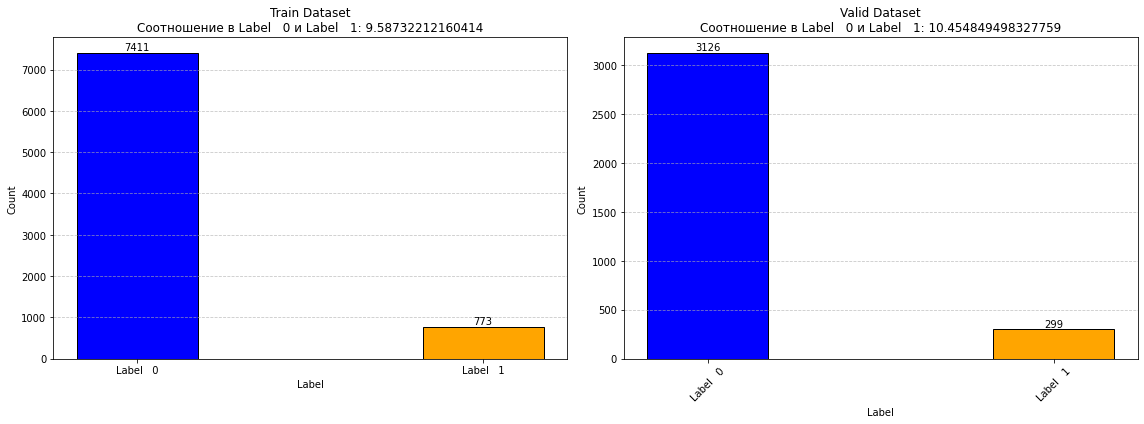

In [9]:
fig, axs = plt.subplots(1,  2, figsize=(16,  6))

datasets = [train_data, valid_data]
titles = ['Train Dataset', 'Valid Dataset']

for i, data in enumerate(datasets):
    label_counts = data['label'].value_counts()
    ratio = label_counts[0] / label_counts[1]
    positions = ['Label   0', 'Label   1']
    counts = [label_counts[0], label_counts[1]]
    bar_width =  0.35

    ax = axs[i]
    rects = ax.bar(positions, counts, width=bar_width, color=['blue', 'orange'], edgecolor='black')
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() /  2, height, str(height), ha='center', va='bottom')

    ax.set_xlabel('Label')
    ax.set_ylabel('Count')
    ax.set_title(f'{titles[i]}\nСоотношение в Label   0 и Label   1: {ratio}')

    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [10]:
label_counts = train_data['label'].value_counts()

trace = go.Bar(
    x=['Label  0', 'Label  1'],
    y=[label_counts[0], label_counts[1]],
    text=[label_counts[0], label_counts[1]],
    marker=dict(
        color=['rgb(58,  71,  80)', 'rgb(255,  87,  51)']
    ),
    orientation='v'
)

layout = go.Layout(
    title='Distribution of Labels',
    xaxis=dict(
        title='Label'
    ),
    yaxis=dict(
        title='Count'
    )
)

data = [trace]

init_notebook_mode(connected=True)
iplot({'data': data, 'layout': layout})


## Токенизация, лемматизация, накидывание признаков

In [11]:
train_data = train_data.drop('tweet_id', axis=1)
test_data = test_data.drop('tweet_id', axis=1)
valid_data = valid_data.drop('tweet_id', axis=1)

In [12]:
train_data

,tweet,label
0,"Настало время для ингаляторов. Дружок, Сальбут...",0
1,15) На прошлой зимней олимпиаде большинство лы...,1
2,Не соглашусь с заменой ЗОК на метопролол в так...,0
3,"@di2m1 мезим Смекта Если отравление, то лоперамид",0
4,Уберите микроволновки и имодиум Действуют соу...,0
...,...,...
8179,"Ну, это всё же имеет временные рамки, а я всю ...",0
8180,"Не помогает:( Ни Де-нол, ни Нексиум. Длительно...",0
8181,@ilyaliya озельтамивир купи в аптеке. А дальше...,0
8182,"я ща угандошусь сальбутамолом, потому что меня...",0


In [13]:
def clean_lemmatize_token(tweet):

    cleaned = tweet.translate(str.maketrans('', '', string.punctuation)).lower()

    tokenized = word_tokenize(cleaned)

    lemmatizer = WordNetLemmatizer()
    lemmatized = [lemmatizer.lemmatize(word) for word in tokenized]

    lemmatized_text = ' '.join(lemmatized)
    return lemmatized_text

train_data['tweet'] = train_data['tweet'].apply(clean_lemmatize_token)
test_data['tweet'] = test_data['tweet'].apply(clean_lemmatize_token)
valid_data['tweet'] = valid_data['tweet'].apply(clean_lemmatize_token)

In [14]:
def lemmatize_tweet(tweet):
    tokens = tweet.split()

    lemmatized_tokens = [simplemma.lemmatize(token, 'ru') for token in tokens]

    lemmatized_text = ' '.join(lemmatized_tokens)
    return lemmatized_text

train_data['lemmatized'] = train_data['tweet'].apply(lemmatize_tweet)
test_data['lemmatized'] = test_data['tweet'].apply(lemmatize_tweet)
valid_data['lemmatized'] = valid_data['tweet'].apply(lemmatize_tweet)


In [15]:
train_data

,tweet,label,lemmatized
0,настало время для ингаляторов дружок сальбутам...,0,настать года для ингалятор дружок сальбутамол ...
1,15 на прошлой зимней олимпиаде большинство лыж...,1,15 на прошлый зимний олимпиада большинство лыж...
2,не соглашусь с заменой зок на метопролол в так...,0,не согласиться с замена зок на метопролол в та...
3,di2m1 мезим смекта если отравление то лоперамид,0,di2m1 мезим смекта если отравление тот лоперамид
4,уберите микроволновки и имодиум действуют соул...,0,убрать микроволновка и имодиум действовать соу...
...,...,...,...
8179,ну это всё же имеет временные рамки а я всю жи...,0,ну этот весь же иметь временный рамка а я весь...
8180,не помогает ни денол ни нексиум длительно hp р...,0,не помогать ни денол ни нексиум длительный hp ...
8181,ilyaliya озельтамивир купи в аптеке а дальше с...,0,ilyaliya озельтамивир купить в аптека а дальни...
8182,я ща угандошусь сальбутамолом потому что меня ...,0,я ща угандошусь сальбутамол потому что меня эт...


In [16]:
train_data = train_data.drop('tweet', axis=1)
test_data = test_data.drop('tweet', axis=1)
valid_data = valid_data.drop('tweet', axis=1)
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)
valid_data = valid_data.reset_index(drop=True)

In [17]:
lemmatized_tweets = train_data['lemmatized'].apply(lambda x: x.split())

In [18]:
def count_lemmas(lemmatized_text):
    words = lemmatized_text.split()
    return len(words)

def count_pos_tags(lemmatized_text, pos_tags):
    tagged_words = pos_tag(word_tokenize(lemmatized_text))
    return sum(1 for word, tag in tagged_words if tag in pos_tags)

noun_pos_tags = ['NN', 'NNS', 'NNP', 'NNPS']
verb_pos_tags = ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']
adjective_pos_tags = ['JJ', 'JJR', 'JJS']

In [19]:
train_data['num_lemmas'] = train_data['lemmatized'].apply(count_lemmas)
test_data['num_lemmas'] = test_data['lemmatized'].apply(count_lemmas)

In [20]:
train_data['num_nouns'] = train_data['lemmatized'].apply(lambda x: count_pos_tags(x, noun_pos_tags))
train_data['num_verbs'] = train_data['lemmatized'].apply(lambda x: count_pos_tags(x, verb_pos_tags))
train_data['num_adjectives'] = train_data['lemmatized'].apply(lambda x: count_pos_tags(x, adjective_pos_tags))

test_data['num_nouns'] = test_data['lemmatized'].apply(lambda x: count_pos_tags(x, noun_pos_tags))
test_data['num_verbs'] = test_data['lemmatized'].apply(lambda x: count_pos_tags(x, verb_pos_tags))
test_data['num_adjectives'] = test_data['lemmatized'].apply(lambda x: count_pos_tags(x, adjective_pos_tags))

In [21]:
valid_data['num_lemmas'] = valid_data['lemmatized'].apply(count_lemmas)

valid_data['num_nouns'] = valid_data['lemmatized'].apply(lambda x: count_pos_tags(x, noun_pos_tags))
valid_data['num_verbs'] = valid_data['lemmatized'].apply(lambda x: count_pos_tags(x, verb_pos_tags))
valid_data['num_adjectives'] = valid_data['lemmatized'].apply(lambda x: count_pos_tags(x, adjective_pos_tags))


In [22]:
train_data

,label,lemmatized,num_lemmas,num_nouns,num_verbs,num_adjectives
0,0,настать года для ингалятор дружок сальбутамол ...,8,7,0,1
1,1,15 на прошлый зимний олимпиада большинство лыж...,44,42,0,1
2,0,не согласиться с замена зок на метопролол в та...,30,27,1,1
3,0,di2m1 мезим смекта если отравление тот лоперамид,7,7,0,0
4,0,убрать микроволновка и имодиум действовать соу...,6,5,0,1
...,...,...,...,...,...,...
8179,0,ну этот весь же иметь временный рамка а я весь...,15,14,0,1
8180,0,не помогать ни денол ни нексиум длительный hp ...,18,17,0,1
8181,0,ilyaliya озельтамивир купить в аптека а дальни...,18,18,0,0
8182,0,я ща угандошусь сальбутамол потому что меня эт...,9,8,0,1


In [23]:
test_data

,lemmatized,num_lemmas,num_nouns,num_verbs,num_adjectives
0,от паксила такой дикий сонливость,5,4,0,1
1,kyzzenish попробовать парацетамол нередкий оче...,10,9,0,1
2,а для фанат арбидола мочь сообщить что спонсор...,20,19,0,1
3,опять болеть горло поэтому опять забить на бас...,14,13,0,1
4,у васи жар аж весь кровать и одеяло мокрый 😱 д...,22,21,0,1
...,...,...,...,...,...
9090,23 февраль парацетамол успешный защищать меня ...,9,7,0,1
9091,темп быть 389 выпить парацетамол и аспирин ста...,9,4,1,1
9092,врач идиот набрать по объявление температура 3...,16,13,1,1
9093,амоксициллин можно вывести способ гемодиализа,5,4,0,1


# Обучение

In [24]:
X = train_data.drop('label', axis=1)
y = train_data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(6547, 5)
(1637, 5)
(6547,)
(1637,)


In [26]:
X_train

,lemmatized,num_lemmas,num_nouns,num_verbs,num_adjectives
2926,заорать кома нахуй этот тред нужный я вот ксан...,14,11,1,1
3781,ее за одно тамифлю надо к стенка ставить,8,7,0,1
4498,быть неплохой штука флуоксетин хд но этот уж к...,12,11,0,1
4141,nightbvrd лоперамидиммодиумлопедиум для завязы...,44,43,0,1
5244,кто пользоваться бисаком флуоксетиной и фуросе...,12,11,0,1
...,...,...,...,...,...
5226,выпить утро кветиапин спать весить класс деть,7,6,0,1
5390,у меня для этот сиозам и прозак но не отказать...,13,12,0,1
860,дозировка оланзапина и вальдоксан на ночь амин...,13,12,0,1
7603,а ведь он мочь бы простой 50 мг силденафила пр...,12,9,1,1


In [27]:
y_train

2926    0
3781    0
4498    0
4141    0
5244    0
       ..
5226    1
5390    0
860     0
7603    0
7270    0
Name: label, Length: 6547, dtype: int64

In [28]:
transformer = ColumnTransformer(
    transformers=[
        ('lemmatized_tfidf', TfidfVectorizer(max_features=1000), 'lemmatized')
    ],
    remainder='passthrough' 
)

In [29]:
X_train_encoded = transformer.fit_transform(X_train)
X_test_encoded = transformer.transform(X_test)

In [30]:
print(X_train_encoded.shape)
print(X_test_encoded.shape)
print(y_train.shape)
print(y_test.shape)

(6547, 1004)
(1637, 1004)
(6547,)
(1637,)


## Бейзлайн

In [31]:
model = LogisticRegression()
model.fit(X_train_encoded, y_train)
y_pred = model.predict_proba(X_test_encoded)[:,  1]

roc_auc = roc_auc_score(y_test, y_pred)
print('ROC-AUC Score:', roc_auc)

ROC-AUC Score: 0.8552126538465258


c:\Users\HP\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



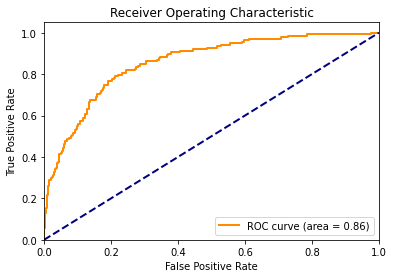

In [32]:
fpr, tpr, _ = roc_curve(y_test, y_pred)

roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0,  1], [0,  1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0,  1.0])
plt.ylim([0.0,  1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Выбираем модель

### Метод опорных векторов

In [33]:
param_grid = {
    'C': [0.1,  1,  10,  100],
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf', 'poly']
}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

model = SVC()

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='roc_auc', cv=2, n_jobs=-1, verbose=1)
grid_result_svm = grid_search.fit(X_train_encoded, y_train)

Fitting 2 folds for each of 16 candidates, totalling 32 fits


In [34]:
print("Best: %f using %s" % (grid_result_svm.best_score_, grid_result_svm.best_params_))

means = grid_result_svm.cv_results_['mean_test_score']
stds = grid_result_svm.cv_results_['std_test_score']
params = grid_result_svm.cv_results_['params']

for mean, std, param in zip(means, stds, params):
    print("%0.3f (+/-%0.03f) with: %r" % (mean, std *  2, param))

Best: 0.780656 using {'C': 100, 'gamma': 'auto', 'kernel': 'rbf'}
0.720 (+/-0.052) with: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
0.750 (+/-0.009) with: {'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}
0.676 (+/-0.093) with: {'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}
0.749 (+/-0.002) with: {'C': 0.1, 'gamma': 'auto', 'kernel': 'poly'}
0.775 (+/-0.024) with: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
0.733 (+/-0.028) with: {'C': 1, 'gamma': 'scale', 'kernel': 'poly'}
0.779 (+/-0.024) with: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
0.734 (+/-0.027) with: {'C': 1, 'gamma': 'auto', 'kernel': 'poly'}
0.778 (+/-0.015) with: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
0.731 (+/-0.029) with: {'C': 10, 'gamma': 'scale', 'kernel': 'poly'}
0.781 (+/-0.009) with: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
0.731 (+/-0.029) with: {'C': 10, 'gamma': 'auto', 'kernel': 'poly'}
0.777 (+/-0.013) with: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
0.719 (+/-0.027) with: {'C': 100, 'gamma': 'scale

In [35]:
best_model_svm = grid_result_svm.best_estimator_
best_model_svm.fit(X_train_encoded, y_train)

test_score = best_model_svm.score(X_test_encoded, y_test)

print("Test ROC-AUC Score: ", test_score)


Test ROC-AUC Score:  0.9156994502138057


## CatBoost

In [36]:
param_grid = {
    'depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'iterations': [200]
}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=12345)

model = CatBoostClassifier(random_state=12345, verbose=1)

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='roc_auc', cv=cv, n_jobs=-1, verbose=1)

grid_result_cb = grid_search.fit(X_train_encoded, y_train)

Fitting 30 folds for each of 45 candidates, totalling 1350 fits
0:	learn: 0.6093541	total: 183ms	remaining: 36.5s
1:	learn: 0.5425541	total: 227ms	remaining: 22.4s
2:	learn: 0.4922210	total: 268ms	remaining: 17.6s
3:	learn: 0.4497424	total: 309ms	remaining: 15.1s
4:	learn: 0.4178922	total: 351ms	remaining: 13.7s
5:	learn: 0.3949536	total: 393ms	remaining: 12.7s
6:	learn: 0.3771758	total: 438ms	remaining: 12.1s
7:	learn: 0.3624829	total: 477ms	remaining: 11.5s
8:	learn: 0.3500108	total: 516ms	remaining: 11s
9:	learn: 0.3382719	total: 558ms	remaining: 10.6s
10:	learn: 0.3293861	total: 598ms	remaining: 10.3s
11:	learn: 0.3220736	total: 641ms	remaining: 10s
12:	learn: 0.3167505	total: 680ms	remaining: 9.79s
13:	learn: 0.3095538	total: 718ms	remaining: 9.54s
14:	learn: 0.3051547	total: 761ms	remaining: 9.38s
15:	learn: 0.3012701	total: 799ms	remaining: 9.18s
16:	learn: 0.2980408	total: 839ms	remaining: 9.03s
17:	learn: 0.2950969	total: 878ms	remaining: 8.88s
18:	learn: 0.2912665	total: 918m

In [37]:
print("Best: %f using %s" % (grid_result_cb.best_score_, grid_result_cb.best_params_))

means = grid_result_cb.cv_results_['mean_test_score']
stds = grid_result_cb.cv_results_['std_test_score']
params = grid_result_cb.cv_results_['params']

for mean, std, param in zip(means, stds, params):
    print("%0.3f (+/-%0.03f) with: %r" % (mean, std *  2, param))

Best: 0.815995 using {'depth': 5, 'iterations': 200, 'l2_leaf_reg': 9, 'learning_rate': 0.1}
0.774 (+/-0.044) with: {'depth': 3, 'iterations': 200, 'l2_leaf_reg': 1, 'learning_rate': 0.01}
0.806 (+/-0.044) with: {'depth': 3, 'iterations': 200, 'l2_leaf_reg': 1, 'learning_rate': 0.05}
0.812 (+/-0.043) with: {'depth': 3, 'iterations': 200, 'l2_leaf_reg': 1, 'learning_rate': 0.1}
0.774 (+/-0.038) with: {'depth': 3, 'iterations': 200, 'l2_leaf_reg': 3, 'learning_rate': 0.01}
0.806 (+/-0.042) with: {'depth': 3, 'iterations': 200, 'l2_leaf_reg': 3, 'learning_rate': 0.05}
0.815 (+/-0.040) with: {'depth': 3, 'iterations': 200, 'l2_leaf_reg': 3, 'learning_rate': 0.1}
0.773 (+/-0.041) with: {'depth': 3, 'iterations': 200, 'l2_leaf_reg': 5, 'learning_rate': 0.01}
0.806 (+/-0.041) with: {'depth': 3, 'iterations': 200, 'l2_leaf_reg': 5, 'learning_rate': 0.05}
0.812 (+/-0.046) with: {'depth': 3, 'iterations': 200, 'l2_leaf_reg': 5, 'learning_rate': 0.1}
0.774 (+/-0.042) with: {'depth': 3, 'iteration

### 

In [38]:
best_model_cb = grid_result_cb.best_estimator_
best_model_cb.fit(X_train_encoded, y_train)

test_score = best_model_cb.score(X_test_encoded, y_test)

print("Test ROC-AUC Score: ", test_score)

0:	learn: 0.6093541	total: 49ms	remaining: 9.76s
1:	learn: 0.5425541	total: 95.3ms	remaining: 9.44s
2:	learn: 0.4922210	total: 140ms	remaining: 9.19s
3:	learn: 0.4497424	total: 181ms	remaining: 8.89s
4:	learn: 0.4178922	total: 223ms	remaining: 8.71s
5:	learn: 0.3949536	total: 266ms	remaining: 8.6s
6:	learn: 0.3771758	total: 309ms	remaining: 8.52s
7:	learn: 0.3624829	total: 353ms	remaining: 8.46s
8:	learn: 0.3500108	total: 392ms	remaining: 8.32s
9:	learn: 0.3382719	total: 432ms	remaining: 8.21s
10:	learn: 0.3293861	total: 471ms	remaining: 8.1s
11:	learn: 0.3220736	total: 511ms	remaining: 8.01s
12:	learn: 0.3167505	total: 553ms	remaining: 7.96s
13:	learn: 0.3095538	total: 594ms	remaining: 7.89s
14:	learn: 0.3051547	total: 635ms	remaining: 7.83s
15:	learn: 0.3012701	total: 680ms	remaining: 7.82s
16:	learn: 0.2980408	total: 723ms	remaining: 7.79s
17:	learn: 0.2950969	total: 770ms	remaining: 7.78s
18:	learn: 0.2912665	total: 812ms	remaining: 7.73s
19:	learn: 0.2894426	total: 852ms	remaining

In [39]:
with open('best_model_cb.pkl', 'wb') as file:
    pickle.dump(best_model_cb, file)

In [40]:
with open('best_model_cb.pkl', 'rb') as file:
    best_model_cb = pickle.load(file)

## Тест

In [41]:
display(test_data)

,lemmatized,num_lemmas,num_nouns,num_verbs,num_adjectives
0,от паксила такой дикий сонливость,5,4,0,1
1,kyzzenish попробовать парацетамол нередкий оче...,10,9,0,1
2,а для фанат арбидола мочь сообщить что спонсор...,20,19,0,1
3,опять болеть горло поэтому опять забить на бас...,14,13,0,1
4,у васи жар аж весь кровать и одеяло мокрый 😱 д...,22,21,0,1
...,...,...,...,...,...
9090,23 февраль парацетамол успешный защищать меня ...,9,7,0,1
9091,темп быть 389 выпить парацетамол и аспирин ста...,9,4,1,1
9092,врач идиот набрать по объявление температура 3...,16,13,1,1
9093,амоксициллин можно вывести способ гемодиализа,5,4,0,1


In [42]:
test_data_encoded = transformer.transform(test_data)


In [43]:
predictions_svm = best_model_svm.predict(test_data_encoded)
predictions_cb = best_model_cb.predict(test_data_encoded)

In [44]:
results = pd.concat([test_data_orig, pd.Series(predictions_svm, name='prediction_svm')], axis=1)
results = pd.concat([results, pd.Series(predictions_cb, name='prediction_cb')], axis=1)

In [45]:
results['prediction_cb'].value_counts()

0    8684
1     411
Name: prediction_cb, dtype: int64

In [46]:
results['prediction_svm'].value_counts()

0    9095
Name: prediction_svm, dtype: int64

In [47]:
display(results)

,tweet_id,tweet,prediction_svm,prediction_cb
0,1149390095612555266,от паксила такая дикая сонливость((,0,0
1,1104439603304546304,@Kyzzenish Попробуйте парацетамол. Нередко оче...,0,0
2,5886509017,"А для фанатов арбидола могу сообщить, что спон...",0,0
3,1539809930,"Опять болит горло, поэтому опять забил на басс...",0,0
4,777843779021709312,"У Васи жар, аж вся кровать и одеяло мокрые 😱 д...",0,0
...,...,...,...,...
9090,1231489126068899841,23 февраля парацетамол успешно защищает меня о...,0,0
9091,945452174762536961,Темпа была 38.9 Выпила парацетамол и аспирин с...,0,0
9092,606052591064248320,врачи идиоты. наберут по объявлению. температу...,0,0
9093,498394370341875712,Амоксициллин можно вывести способом гемодиализа.,0,0


In [48]:
results = results.drop(['tweet', 'prediction_svm'], axis=1)

In [49]:
results

,tweet_id,prediction_cb
0,1149390095612555266,0
1,1104439603304546304,0
2,5886509017,0
3,1539809930,0
4,777843779021709312,0
...,...,...
9090,1231489126068899841,0
9091,945452174762536961,0
9092,606052591064248320,0
9093,498394370341875712,0


In [50]:
results = results.rename(columns={'prediction_cb': 'label'})

In [51]:
results

,tweet_id,label
0,1149390095612555266,0
1,1104439603304546304,0
2,5886509017,0
3,1539809930,0
4,777843779021709312,0
...,...,...
9090,1231489126068899841,0
9091,945452174762536961,0
9092,606052591064248320,0
9093,498394370341875712,0


In [52]:
results.to_csv('results.csv', index=False)

In [53]:
##